In [ ]:
from abc import ABC, abstractmethod

from matplotlib import backends
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetworkBase(ABC):
    @abstractmethod
    def __init__(self, image_size, color_channels, embedding_size):
        pass

    @abstractmethod
    def forward_once(self, x):
        pass

    @abstractmethod
    def forward(self, input1, input2):
        pass

    @abstractmethod
    def compute_embedding(self, x):
        pass

    @abstractmethod
    def save_model(self, filepath):
        pass

    @abstractmethod
    def load_model(self, filepath):
        pass

class SiameseNetworkPyTorch(SiameseNetworkBase, nn.Module):
    def __init__(self, image_size=(105, 105), color_channels=1, embedding_size=128):
        nn.Module.__init__(self)
        SiameseNetworkBase.__init__(self, image_size, color_channels, embedding_size)
        self.image_size = image_size
        self.color_channels = color_channels
        self.embedding_size = embedding_size
        self.transform = None

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.color_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        # Calculate the size after convolutional layers to define the first linear layer
        #self._to_linear = self._calculate_conv_output_size()

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, embedding_size)
        )

        # Initialize weights
        self._initialize_weights()

    def _calculate_conv_output_size(self):
        # Dummy input to calculate the size
        with torch.no_grad():
            #print(f"Calculating the size after convolutional layers... (input size: {self.color_channels}x{self.image_size[0]}x{self.image_size[1]})")
            x = torch.zeros(1, self.color_channels, *self.image_size)
            x = self.conv_layers(x)
            return x.view(1, -1).size(1)

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    @staticmethod
    def load_trained_model(filepath, image_size=(105, 105), color_channels=3, embedding_size=128):
        """
        Loads a trained Siamese network from a saved state dict.

        Args:
            filepath (str): Path to the saved model file.
            image_size (tuple): Size of the input images.
            color_channels (int): Number of color channels.
            embedding_size (int): Size of the embedding vector.

        Returns:
            SiameseNetworkPyTorch: An instance of the loaded model.
        """
        model = SiameseNetworkPyTorch(
            image_size=image_size,
            color_channels=color_channels,
            embedding_size=embedding_size
        )
        model.load_model(filepath)
        model.eval()
        return model

    def predict(self, img1, img2, transform, threshold):
        """
        Predicts whether two images are similar or dissimilar.

        Args:
            img1 (PIL.Image or str): First image or path to the image.
            img2 (PIL.Image or str): Second image or path to the image.
            transform (callable): Transformations to apply to the images.
            threshold (float): Threshold for determining similarity.

        Returns:
            float: The Euclidean distance between the embeddings.
            int: Prediction label (0 for similar, 1 for dissimilar).
        """
        # Load images if paths are provided
        if isinstance(img1, str):
            img1 = Image.open(img1).convert('RGB')
        if isinstance(img2, str):
            img2 = Image.open(img2).convert('RGB')

        # Apply transformations
        img1 = transform(img1).unsqueeze(0)  # Add batch dimension
        img2 = transform(img2).unsqueeze(0)

        # Move to device
        device = next(self.parameters()).device
        img1 = img1.to(device)
        img2 = img2.to(device)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.forward_once(img1)
            output2 = self.forward_once(img2)

        # Compute Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2).item()

        # Make prediction based on threshold
        prediction = 1 if euclidean_distance > threshold else 0

        return euclidean_distance, prediction

    def compute_embedding(self, img, transform):
        """
        Computes the embedding for a single image.

        Args:
            img (PIL.Image or str): Image or path to the image.
            transform (callable): Transformations to apply to the image.

        Returns:
            Tensor: Embedding vector.
        """
        # Load image if path is provided
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        # Apply transformations
        img = transform(img).unsqueeze(0)  # Add batch dimension

        # Move to device
        device = next(self.parameters()).device
        img = img.to(device)

        # Compute embedding
        with torch.no_grad():
            embedding = self.forward_once(img)

        return embedding.cpu().numpy().flatten()

    def save_model(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_model(self, filepath):
        self.load_state_dict(torch.load(filepath))

    def _initialize_weights(self):
        # Initialize weights using Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


from abc import ABC, abstractmethod
from torch.utils.data import Dataset

class SiameseDatasetBase(Dataset, ABC):
    def __init__(self, transform=None, callbacks=None):
        """
        Base class for Siamese datasets.

        Args:
            transform (callable, optional): Optional transform to be applied on a sample.
            callbacks (dict, optional): Dictionary of callback functions for data retrieval.
        """
        self.transform = transform
        self.callbacks = callbacks or {}

    @abstractmethod
    def __getitem__(self, index):
        pass

    @abstractmethod
    def __len__(self):
        pass

import os
import random
from PIL import Image
import torch

class SiameseDatasetFromPaths(SiameseDatasetBase):
    def __init__(self, image_folder_dataset, transform=None, num_pairs=10000):
        super().__init__(transform=transform)
        self.image_folder_dataset = image_folder_dataset
        self.classes = list(self.image_folder_dataset.keys())
        self.transform = transform

        # Precompute pairs
        self.pairs = []
        for _ in range(num_pairs):
            should_get_same_class = random.randint(0, 1)
            class1 = random.choice(self.classes)
            img1_path = random.choice(self.image_folder_dataset[class1])

            if should_get_same_class or len(self.classes) < 2:
                # Positive pair
                class2 = class1
                label = 0.0
            else:
                # Negative pair
                class2 = random.choice(self.classes)
                while class1 == class2:
                    class2 = random.choice(self.classes)
                label = 1.0

            img2_path = random.choice(self.image_folder_dataset[class2])
            self.pairs.append((img1_path, img2_path, label))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]

        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)
    
def build_image_dataset_from_directory(root_dir):
    """
    Builds a dictionary where each key is a class label and the value is a list of image paths.
    
    Args:
        root_dir (str): Path to the root directory ('train' or 'val').
    
    Returns:
        dict: A dictionary with class labels as keys and lists of image paths as values.
    """
    image_dataset = {}
    classes = os.listdir(root_dir)
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)
                      if img.lower().endswith(('jpg', 'png', 'jpeg'))]
            if images:
                image_dataset[cls] = images
    return image_dataset

import torch
from PIL import Image
import numpy as np

class SiameseDatasetFromCpp(SiameseDatasetBase):
    def __init__(self, transform=None, callbacks=None):
        super().__init__(transform=transform, callbacks=callbacks)

        if 'get_data' not in self.callbacks:
            raise ValueError("Callback 'get_data' must be provided for SiameseDatasetFromCpp")

        # Optionally, initialize any required state or connection here
        # For example, establish a connection to the C++ application if needed

    def __getitem__(self, index):
        """
        Retrieves a data sample from the C++ application via the 'get_data' callback.

        Args:
            index (int): Index of the sample. Since data is provided via callback, index can be ignored.

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Tuple containing the two images and the label.
        """
        # Fetch image data and label from the C++ application via the 'get_data' callback
        img1_data, img2_data, label = self.callbacks['get_data']()

        # Convert raw data to PIL Images
        img1 = Image.fromarray(img1_data).convert('RGB')
        img2 = Image.fromarray(img2_data).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label_tensor = torch.tensor([label], dtype=torch.float32)

        return img1, img2, label_tensor

    def __len__(self):
        """
        Returns the length of the dataset.

        Since data is provided on-demand from the C++ application, we can set an arbitrary large number
        or manage the length via a callback if needed.

        Returns:
            int: Length of the dataset.
        """
        if 'get_length' in self.callbacks:
            return self.callbacks['get_length']()
        else:
            # Return a large number to simulate an infinite dataset
            return 1000000
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive
    
# siamese_trainer.py

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

from tqdm import tqdm

# Import or define your model and dataset classes here
# from siamese_network import SiameseNetworkPyTorch
# from contrastive_loss import ContrastiveLoss
# from siamese_dataset import SiameseDatasetFromPaths, SiameseDatasetFromCpp

class SiameseTrainer:
    @staticmethod
    def train_model(
        model_params,
        train_dataset_params,
        val_dataset_params,
        training_params,
        callbacks
    ):
        """
        Static method to train the Siamese network.

        Args:
            model_params (dict): Parameters for model initialization.
            train_dataset_params (dict): Parameters for the training dataset.
            training_params (dict): Training parameters (epochs, batch_size, learning_rate, etc.).
            callbacks (dict): Dictionary of callback functions.
        """
        # Unpack model parameters
        image_size = model_params.get('image_size', (105, 105))
        color_channels = model_params.get('color_channels', 3)
        embedding_size = model_params.get('embedding_size', 128)

        # Unpack training parameters
        num_epochs = training_params.get('num_epochs', 10)
        batch_size = training_params.get('batch_size', 32)
        learning_rate = training_params.get('learning_rate', 0.0005)
        max_batches = training_params.get('max_batches', None)
        margin = training_params.get('margin', 2.0)
        threshold = training_params.get('threshold', margin / 2.0)
        device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

        # Define transformations
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*color_channels, std=[0.5]*color_channels)
        ])

        # Initialize the training dataset
        train_dataset_class = train_dataset_params.get('dataset_class', 'paths')
        if train_dataset_class == 'dataset':
            train_dataset = train_dataset_params.get('data')
        elif train_dataset_class == 'paths':
            train_dataset = SiameseDatasetFromPaths(train_dataset_params.get('data'), transform=transform)
        elif train_dataset_class == 'cpp':
            train_dataset = SiameseDatasetFromCpp(transform=transform, callbacks=callbacks)
        else:
            raise ValueError("Invalid train dataset_class specified.")

        # Initialize the validation dataset
        val_dataset_class = val_dataset_params.get('dataset_class', 'paths')
        if val_dataset_class == 'dataset':
            val_dataset = val_dataset_params.get('data')
        elif val_dataset_class == 'paths':
            val_dataset = SiameseDatasetFromPaths(val_dataset_params.get('data'), transform=transform)
        elif val_dataset_class == 'cpp':
            val_dataset = SiameseDatasetFromCpp(transform=transform, callbacks=callbacks)
        else:
            raise ValueError("Invalid val dataset_class specified.")

        # DataLoaders
        train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
        val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=0)

        import matplotlib.pyplot as plt

        # Plot a fixed number of example images from the train_loader
        for i, (img1, img2, label) in enumerate(train_loader):
            if i >= 3:
                break

            # Display the images
            img1, img2 = img1[0], img2[0]
            img1 = (img1 * 0.5 + 0.5).numpy().transpose(1, 2, 0)
            img2 = (img2 * 0.5 + 0.5).numpy().transpose(1, 2, 0)

            # Display the images
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img1)
            plt.title("Image 1")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(img2)
            plt.title("Image 2")
            plt.axis('off')
            plt.show()


        # Initialize the model
        model = SiameseNetworkPyTorch(
            image_size=image_size,
            color_channels=color_channels,
            embedding_size=embedding_size
        )
        model.transform = transform  # Store the transform for later use
        model = model.to(device)

        # Loss function and optimizer
        criterion = ContrastiveLoss(margin=margin)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            print(f"Starting epoch {epoch}/{num_epochs}")

            for batch_idx, (img1, img2, label) in enumerate(tqdm(train_loader)):
                if max_batches and batch_idx >= max_batches:
                    break  # Limit the number of batches if desired

                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                #print(img1.shape, img2.shape, label.shape)

                optimizer.zero_grad()

                # Forward pass
                output1, output2 = model(img1, img2)

                # Compute loss
                loss = criterion(output1, output2, label)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                # Compute distances
                euclidean_distance = F.pairwise_distance(output1, output2)

                # Make predictions based on threshold
                pred = (euclidean_distance > threshold).float()

                # Compare predictions with labels
                correct += (pred == label).sum().item()
                total += label.size(0)

                # Call the 'on_batch_end' callback
                if 'on_batch_end' in callbacks:
                    callbacks['on_batch_end'](epoch, batch_idx, loss.item())

            avg_loss = epoch_loss / (batch_idx + 1)
            train_acc = correct / total

            print(f"Epoch [{epoch}/{num_epochs}] completed. Average Training Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Perform validation
            val_loss, val_acc = SiameseTrainer.validate_model(model, val_loader, criterion, device, threshold)
            print(f"Epoch [{epoch}/{num_epochs}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

            # Call the 'on_epoch_end' callback
            if 'on_epoch_end' in callbacks:
                callbacks['on_epoch_end'](epoch, avg_loss, train_acc, val_loss, val_acc)

            # Optionally, save the model after each epoch
            if 'save_model' in callbacks:
                callbacks['save_model'](model, epoch)

        # Call the 'on_training_end' callback
        if 'on_training_end' in callbacks:
            callbacks['on_training_end'](model)

        return model  # Return the trained model
    
    @staticmethod
    def validate_model(model, val_loader, criterion, device, threshold):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (img1, img2, label) in enumerate(tqdm(val_loader)):
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                # Forward pass
                output1, output2 = model(img1, img2)

                # Compute loss
                loss = criterion(output1, output2, label)

                val_loss += loss.item()

                # Compute distances
                euclidean_distance = F.pairwise_distance(output1, output2)

                # Make predictions based on threshold
                pred = (euclidean_distance > threshold).float()

                # Compare predictions with labels
                correct += (pred == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / (batch_idx + 1)
        val_acc = correct / total

        return avg_val_loss, val_acc

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define dummy callbacks
def on_batch_end(epoch, batch_idx, loss):
    pass
    #print(f"[Callback] Epoch {epoch}, Batch {batch_idx}, Loss: {loss:.4f}")

def on_epoch_end(epoch, avg_train_loss, train_acc, avg_val_loss, val_acc):
    print(f"[Callback] Epoch {epoch} ended.")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

def save_model(model, epoch):
    # For testing, we won't actually save the model
    print(f"[Callback] Model saved at epoch {epoch}")

def on_training_end(model):
    print("[Callback] Training completed.")

# Assemble the callbacks into a dictionary
callbacks = {
    'on_batch_end': on_batch_end,
    'on_epoch_end': on_epoch_end,
    'save_model': save_model,
    'on_training_end': on_training_end
}


In [ ]:

# Define model parameters
model_params = {
    'image_size': (80, 80),
    'color_channels': 1,
    'embedding_size': 128
}

# Define training parameters
training_params = {
    'num_epochs': 25,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'margin': 2.0,
    'max_batches': 50  # Limit the number of batches for testing
}

# For c++ usage
import numpy as np

def get_data():
    # Generate dummy image data (random noise)
    height, width, channels = 105, 105, 3
    img1_data = np.random.randint(0, 256, (height, width, channels), dtype=np.uint8)
    img2_data = np.random.randint(0, 256, (height, width, channels), dtype=np.uint8)
    label = np.random.choice([0, 1])  # Randomly choose 0 or 1

    return img1_data, img2_data, label

# /// Update callbacks
'''
callbacks['get_data'] = get_data

train_dataset_params = {
    'dataset_class': 'cpp',  # Indicate that we're using the dataset that interfaces with C++
}

# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    training_params,
    callbacks
)
#'''
# ///

#'''
# Build the image dataset
root_dir = 'id_dataset'  # Replace with your dataset path

# Paths to the 'train' and 'val' directories
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# Build the image datasets
train_image_dataset = build_image_dataset_from_directory(train_dir)
val_image_dataset = build_image_dataset_from_directory(val_dir)

# Check the number of classes and images
print(f"Number of classes in training set: {len(train_image_dataset)}")
print(f"Number of classes in validation set: {len(val_image_dataset)}")

# Define training dataset parameters
train_dataset_params = {
    'dataset_class': 'paths',
    'data': train_image_dataset  # The image dataset built earlier
}

# Define validation dataset parameters
val_dataset_params = {
    'dataset_class': 'paths',
    'data': val_image_dataset  # The image dataset built earlier
}
#'''

# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    val_dataset_params,
    training_params,
    callbacks
)


In [166]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

class SiamesePredictor:
    def __init__(self, model_path, model_params, threshold):
        """
        Initializes the predictor with a trained model.

        Args:
            model_path (str): Path to the saved model file.
            model_params (dict): Parameters used to initialize the model.
            threshold (float): Threshold for determining similarity.
        """
        # Extract model parameters
        self.image_size = model_params.get('image_size', (105, 105))
        self.color_channels = model_params.get('color_channels', 3)
        self.embedding_size = model_params.get('embedding_size', 128)

        # Load the model
        if isinstance(model_path, str):
            self.model = SiameseNetworkPyTorch.load_trained_model(
                filepath=model_path,
                image_size=self.image_size,
                color_channels=self.color_channels,
                embedding_size=self.embedding_size
            )
            self.model.to(self.device)
        elif isinstance(model_path, nn.Module):
            self.model = model_path
            #self.device = self.model.device
        else:
            raise ValueError("Invalid model_path provided.")
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

        self.threshold = threshold

        # Define transformations based on color channels
        self.transform = self._get_transform()

    def _get_transform(self):
        """
        Defines the transformations to apply to input images.
        Adjusts for grayscale or RGB images based on the model's color_channels.
        """
        if self.color_channels == 1:
            # Grayscale transformations
            transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            # RGB transformations
            transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*self.color_channels, std=[0.5]*self.color_channels)
            ])
        return transform

    def predict(self, input1, input2):
        """
        Predicts similarity between inputs. Automatically handles different input types.

        Args:
            input1: Single image, list of images, or set of images.
            input2: Single image, list of images, set of images, or dict of sets.

        Returns:
            See the method's docstring in previous answers for possible returns.
        """
        # Handle single image vs single image
        if self._is_single_image(input1) and self._is_single_image(input2):
            distance, prediction = self._predict_single_pair(input1, input2)
            return distance, prediction

        # Handle single image vs list of images
        elif self._is_single_image(input1) and self._is_list_of_images(input2):
            results = self._predict_image_to_images(input1, input2)
            return results

        # Handle list of images vs list of images
        elif self._is_list_of_images(input1) and self._is_list_of_images(input2):
            results = self._predict_images_to_images(input1, input2)
            return results

        # Handle set comparison: input2 is a dict of sets
        elif self._is_list_of_images(input1) and isinstance(input2, dict):
            closest_set, distances = self._compare_set_to_sets(input1, input2)
            return closest_set, distances

        else:
            raise ValueError("Invalid input types for prediction.")

    # Helper methods to determine input types
    def _is_single_image(self, input):
        if isinstance(input, (str, Image.Image)):
            return True
        if isinstance(input, np.ndarray) and (len(input.shape) == 3 or (len(input.shape) == 4 and input.shape[0] == 1)):
            return True
        elif isinstance(input, torch.Tensor) and input.dim() == 4 and input.size(0) == 1:
            return True
        return False

    def _is_list_of_images(self, input):
        if isinstance(input, np.ndarray) and len(input.shape) == 4 and input.shape[0] > 1:
            return True
        return isinstance(input, list) and all(isinstance(i, (str, Image.Image, np.ndarray, torch.Tensor)) for i in input)

    # Prediction methods
    def _predict_single_pair(self, img1, img2):
        # Load and preprocess images
        img1 = self._prepare_input(img1)
        img2 = self._prepare_input(img2)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1)
            output2 = self.model.forward_once(img2)

        # Compute Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2).item()

        # Make prediction
        prediction = 1 if euclidean_distance > self.threshold else 0

        return euclidean_distance, prediction

    def _predict_image_to_images(self, img1, images):
        # Load and preprocess images
        img1 = self._prepare_input(img1)
        img2_batch = self._prepare_batch_input(images)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1)
            output2 = self.model.forward_once(img2_batch)

        # Compute distances
        euclidean_distances = F.pairwise_distance(output1, output2)

        # Make predictions
        preds = (euclidean_distances > self.threshold).float().cpu().numpy().astype(int)
        distances = euclidean_distances.cpu().numpy()

        # Pair image identifiers with results
        results = list(zip(images, distances, preds))

        return results

    def _predict_images_to_images(self, images1, images2):
        # Load and preprocess images
        img1_batch = self._prepare_batch_input(images1)
        img2_batch = self._prepare_batch_input(images2)

        # Ensure same batch size
        if len(images1) != len(images2):
            raise ValueError("Both image lists must have the same number of images.")

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1_batch)
            output2 = self.model.forward_once(img2_batch)

        # Compute distances
        euclidean_distances = F.pairwise_distance(output1, output2)

        # Make predictions
        preds = (euclidean_distances > self.threshold).float().cpu().numpy().astype(int)
        distances = euclidean_distances.cpu().numpy()

        # Pair image identifiers with results
        results = list(zip(images1, images2, distances, preds))

        return results

    def _compare_set_to_sets(self, comp_images, sets_dict):
        """
        Compares a set of images (comp_images) to multiple sets (sets_dict).

        Args:
            comp_images (list): List of images in COMP set.
            sets_dict (dict): Dictionary with set names as keys and list of images as values.

        Returns:
            str: Name of the closest set.
            dict: Average distances to each set.
        """
        comp_embeddings = self._compute_embeddings(comp_images)

        set_distances = {}
        for set_name, images in sets_dict.items():
            set_embeddings = self._compute_embeddings(images)
            # Compute distances between every pair of embeddings
            distances = self._compute_distance_matrix(comp_embeddings, set_embeddings)
            # Compute average distance
            avg_distance = distances.mean()
            set_distances[set_name] = avg_distance

        # Determine the closest set
        closest_set = min(set_distances, key=set_distances.get)

        return closest_set, set_distances

    def _prepare_input(self, img):
        """
        Prepares a single image input, handling different data types efficiently.

        Args:
            img: Image input, can be a path, PIL Image, NumPy array, or tensor.

        Returns:
            Tensor: Preprocessed image tensor ready for model input.
        """
        if isinstance(img, torch.Tensor):
            # Assume tensor is already preprocessed
            img = img.to(self.device)
            if img.dim() == 3:
                img = img.unsqueeze(0)  # Add batch dimension
            return img

        else:
            # Load image if path is provided
            if isinstance(img, str):
                img = Image.open(img)
            elif isinstance(img, np.ndarray):
                # Convert NumPy array to PIL Image
                if img.ndim == 3:
                    if img.shape[2] == 1:
                        # Grayscale image
                        img = Image.fromarray(np.squeeze(img, axis=2).astype('uint8'), mode='L')
                    elif img.shape[2] == 3:
                        # RGB image
                        img = Image.fromarray(img.astype('uint8'), mode='RGB')
                    else:
                        # Handle images with other numbers of channels
                        img = Image.fromarray(img[:, :, :3].astype('uint8'), mode='RGB')
                elif img.ndim == 2:
                    # Grayscale image
                    img = Image.fromarray(img.astype('uint8'), mode='L')
                else:
                    raise ValueError(f"Unsupported NumPy array shape: {img.shape}")
            elif isinstance(img, Image.Image):
                # If it's already a PIL Image, do nothing
                pass
            else:
                raise TypeError(f"Unsupported image type: {type(img)}")

            # Convert image to the appropriate mode
            img = self._convert_image_mode(img)

            # Apply transformations
            img = self.transform(img).unsqueeze(0).to(self.device)
            return img

    def _prepare_batch_input(self, images):
        """
        Prepares a batch of images efficiently.

        Args:
            images: List of image inputs.

        Returns:
            Tensor: Batch of preprocessed images.
        """
        tensors = []
        for img in images:
            tensors.append(self._prepare_input(img))
        # Concatenate tensors along the batch dimension
        batch_tensor = torch.cat(tensors, dim=0)
        return batch_tensor

    def _convert_image_mode(self, img):
        """
        Converts the image to the appropriate mode based on color_channels.

        Args:
            img (PIL.Image): Input image.

        Returns:
            PIL.Image: Image converted to the correct mode.
        """
        if self.color_channels == 1:
            # Convert to grayscale if necessary
            if img.mode != 'L':
                img = img.convert('L')
        else:
            # Convert to RGB if necessary
            if img.mode != 'RGB':
                img = img.convert('RGB')
        return img

    def _compute_embeddings(self, images):
        # Prepare batch input
        img_batch = self._prepare_batch_input(images)

        # Compute embeddings
        with torch.no_grad():
            embeddings = self.model.forward_once(img_batch)

        return embeddings

    def _compute_distance_matrix(self, embeddings1, embeddings2):
        """
        Computes the pairwise distance matrix between two sets of embeddings.

        Args:
            embeddings1 (Tensor): Embeddings of the first set (N x D).
            embeddings2 (Tensor): Embeddings of the second set (M x D).

        Returns:
            Tensor: Distance matrix of size N x M.
        """
        # Compute pairwise distances
        distances = torch.cdist(embeddings1, embeddings2, p=2)  # Euclidean distance

        # Flatten to a single vector
        distances = distances.view(-1)

        return distances
    
# Load a grayscale image as a NumPy array
import cv2
img_array = cv2.imread('id_dataset/val/9/3.png', cv2.IMREAD_GRAYSCALE)  # Shape: (H, W)
img2_array = cv2.imread('id_dataset/val/9/427.png', cv2.IMREAD_GRAYSCALE)  # Shape: (H, W)

# Convert to PIL Image
img_pil = Image.fromarray(img_array)
img2_pil = Image.fromarray(img2_array)

predictor = SiamesePredictor(
    model_path=trained_model,
    model_params=model_params,
    #transform=trained_model.transform,
    threshold=training_params.get('threshold', 1.0)
)

distance, prediction = predictor.predict(img_pil, img2_pil)

print(f"Euclidean Distance: {distance:.4f}")
print(f"Prediction: {'Similar' if prediction == 0 else 'Dissimilar'}")

Euclidean Distance: 1.0119
Prediction: Dissimilar


In [160]:
# Assume img_array is a NumPy array representing an image
img_array = np.random.randint(0, 256, size=(80, 80, 1), dtype=np.uint8)  # Grayscale image

# Use the predictor to prepare the input
prepared_img = predictor._prepare_input(img_array)

print(f"Prepared image shape: {prepared_img.shape}")


Prepared image shape: torch.Size([1, 1, 80, 80])


In [181]:
from glob import glob
import os

root = '/Users/tristan/trex/docs/notebooks/id_dataset'

with np.load("/Users/tristan/Videos/data/group_1_tracklet_images_single_part0.npz") as npz:
    print(npz.files)
    print(npz['ids'].shape) # (192762,)
    print(npz['images'].shape) # (192762, 80, 80, 1)

    images = npz['images']
    frames = npz['frames']

    all_positives = []
    all_negatives = []

    # save these images (sorted by id) to folders.
    # the root folder is given, then below that we create a folder / id and enumerate
    # the images in that folder.

    # create a folder for each id
    for i, id in enumerate(np.unique(npz['ids'])):
        folder = os.path.join(root, str(id))
        #os.makedirs(folder, exist_ok=True)

        mask = npz['ids'] == id
        used_indexes = np.unique(npz['frame_segment_indexes'][mask])
        print(f"id: {id}, images: {npz['images'][mask].shape}, segments: {npz['frame_segments'][used_indexes]}")

        # get number of images / frame segment
        for s in used_indexes:
            mask = npz['frame_segment_indexes'] == s
            N = mask.sum()

            segment = npz["frame_segments"][s]
            L = segment[-1] - segment[0] + 1

            print(f"segment: {segment}, images: {N}, L: {L}")

            if N < 100:
                continue

            my_frames = frames[mask]
            my_images = images[mask]

            # find data of other ids that are in the same frame segment
            current_frame_mask = (frames == my_frames[len(my_frames) // 2]) & (npz['ids'] != id)
            other_indexes = np.unique(npz["frame_segment_indexes"][current_frame_mask])
            #other_segments = np.array([npz["frame_segments"][idx] for idx in other_indexes])

            # calculate the maximum number of positive examples we can get from within
            # the same segment and the current individual (while maintaining a min_distance
            # between the images):
            min_distance = 10
            n_positives = max(1, int(L / min_distance / 2))

            # sample positives
            all_frames = my_frames
            chosen_frames = np.random.choice(all_frames, size=n_positives, replace=False)
            chosen_frames = np.sort(chosen_frames)
            # remove the chosen frames from the list of all frames
            all_frames = np.setdiff1d(all_frames, chosen_frames)

            #print(f"chosen_frames: {chosen_frames} all_frames: {all_frames}")

            # now sample the positives, removing a used paired image from the list of all frames
            positives = []
            for frame in chosen_frames:
                if len(all_frames) == 0:
                    print("***> no more frames to choose from")
                    break

                my_image = my_images[my_frames == frame]
                assert len(my_image) == 1
                my_image = my_image[0]

                # now choose the index of the paired image.
                # prefer to choose an image as far away as possible within the same segment
                paired_frame = all_frames[np.abs(all_frames - frame).argmax()]
                all_frames = np.setdiff1d(all_frames, [paired_frame])

                paired_image = my_images[my_frames == paired_frame]
                assert len(paired_image) == 1

                paired_image = paired_image[0]
                positives.append((0.0, id, frame, my_image, id, paired_frame, paired_image))

            print(f"\tpositives: {len(positives)}")

            # sample images from other segments to get negative examples (dissimilar)
            # we can assume that since the frame segments overlap, both individuals which
            # are visible in the same frame segment are dissimilar. lets sample 10% of the
            # length of the current individuals segment as negative examples.
            n_negatives = max(1, int(1.0 * len(positives)))

            # cache the frames for all other indexes
            other_index_masks = {}
            for idx in other_indexes:
                other_frame_mask = (npz["frame_segment_indexes"] == idx)
                other_index_masks[idx] = (other_frame_mask, npz["ids"][other_frame_mask][0], frames[other_frame_mask], images[other_frame_mask])

            # sample negatives
            chosen_negatives = np.random.randint(0, len(other_indexes), size=n_negatives)
            chosen_indexes = other_indexes[chosen_negatives]

            negatives = []

            for other_index in chosen_indexes:
                # sample a random index from that segment
                other_frame_mask, other_id, _frames, _images = other_index_masks[other_index]

                found = False
                for _ in range(5):
                    index = np.random.randint(0, len(_images))
                    frame = _frames[index]

                    my_image = my_images[my_frames == frame]
                    if len(my_image) == 0:
                        print(f"\t XX frame: {frame} no image found")
                        continue
                    else:
                        my_image = my_image[0]
                        
                        print(f"\t => frame: {frame}, image: {len(my_image)} my_images: {my_images.shape}, other_images: {_images.shape}")
                        print(frame, "in", my_frames)

                        print(f"\t\t my_image: {my_image.shape} other_images: {_images[index].shape}")

                        other_image = (1.0, id, frame, my_image, other_id, frame, _images[index])
                        negatives.append(other_image)
                        found = True
                        break
                
                if not found:
                    print(f"\t ** frame: {frame} no image found at all")

            print(f"\tnegatives: {len(negatives)}")

            all_positives.extend(positives)
            all_negatives.extend(negatives)

            
        #break

    def get_transform(color_channels):
        """
        Returns a transformation function based on the number of color channels.

        Args:
            color_channels (int): Number of color channels.

        Returns:
            callable: Transformation function.
        """
        normalize_mean = [0.5] * color_channels
        normalize_std = [0.5] * color_channels

        def transform(tensor):
            # Assuming tensor is already in (C, H, W) format
            # Normalize the tensor
            tensor = transforms.Normalize(mean=normalize_mean, std=normalize_std)(tensor)
            return tensor

        return transform

    # Define model parameters
    image_size = images.shape[1:-1]
    print(image_size)
    '''model_params = {
        'image_size': image_size,
        'color_channels': images.shape[-1],
        'embedding_size': 128
    }'''



['images', 'dimensions', 'positions', 'frame_segment_indexes', 'frame_segments', 'frames', 'ids', 'encoding']
(192762,)
(192762, 80, 80, 1)
id: 0, images: (19242, 80, 80, 1), segments: [[    0   271]
 [  273  2468]
 [ 2475  3125]
 [ 3133  3876]
 [ 3883  4101]
 [ 4103  4644]
 [ 4647  5046]
 [ 5049  5580]
 [ 5584  5653]
 [ 5655  5834]
 [ 5845  5847]
 [ 5851  6983]
 [ 6984  6984]
 [ 6994  7533]
 [ 7538  8338]
 [ 8340  9380]
 [ 9382  9451]
 [ 9454 12474]
 [12480 13094]
 [13098 17231]
 [17234 17234]
 [17239 17239]
 [17241 19316]]
segment: [  0 271], images: 272, L: 272
	positives: 13
	 XX frame: 949 no image found
	 XX frame: 1005 no image found
	 XX frame: 858 no image found
	 => frame: 8, image: 80 my_images: (272, 80, 80, 1), other_images: (1124, 80, 80, 1)
8 in [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  

In [187]:
import torch
from torch.utils.data import Dataset
import numpy as np
import random

class SiameseDatasetFromArrays(Dataset):
    def __init__(self, positives, negatives, transform=None):
        """
        Initializes the dataset with positive and negative examples.

        Args:
            positives (list): List of positive examples.
            negatives (list): List of negative examples.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.data = positives + negatives  # Combine positive and negative examples
        random.shuffle(self.data)  # Shuffle the combined data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label, id1, frame1, image1, id2, frame2, image2 = item

        # Process images
        img1 = self._process_image(image1)
        img2 = self._process_image(image2)

        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label

    def _process_image(self, image):
        # Convert the NumPy array to a tensor
        # Expected shape: (H, W, C) or (H, W)
        if image.ndim == 3:
            # Image with channels
            image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
        elif image.ndim == 2:
            # Grayscale image, add channel dimension
            image = image[np.newaxis, :, :]
        else:
            raise ValueError(f"Unsupported image shape: {image.shape}")

        # Convert to float and normalize to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Convert to tensor
        img_tensor = torch.from_numpy(image)

        # Apply transformations if any
        if self.transform:
            img_tensor = self.transform(img_tensor)
        else:
            # Normalize manually if no transform is provided
            img_tensor = (img_tensor - 0.5) / 0.5  # Assuming mean=0.5, std=0.5

        return img_tensor

# split the data into training and validation sets
split_ratio = 0.8
split_index = int(split_ratio * len(all_positives))

np.random.shuffle(all_positives)
np.random.shuffle(all_negatives)

train_positives = all_positives[:split_index]
val_positives = all_positives[split_index:]

train_negatives = all_negatives[:split_index]
val_negatives = all_negatives[split_index:]

# Define the model parameters
model_params = {
    'image_size': image_size,
    'color_channels': images.shape[-1],
    'embedding_size': 128
}

# Define the training parameters
training_params = {
    'num_epochs': 25,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'margin': 2.0,
    'threshold': 1.0
}

val_dataset = SiameseDatasetFromArrays(
    val_positives,
    val_negatives,
    transform=transform
)

train_dataset = SiameseDatasetFromArrays(
    train_positives,
    train_negatives,
    transform=transform
)


Number of classes in training set: 15284
Number of classes in validation set: 3009


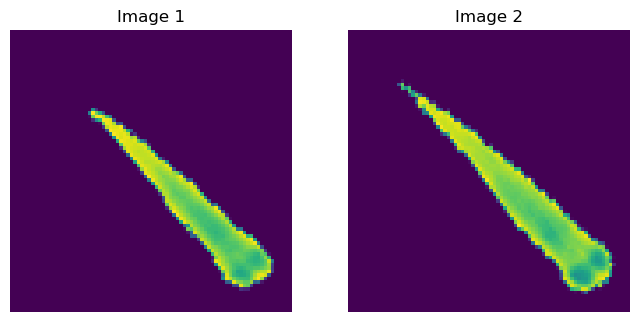

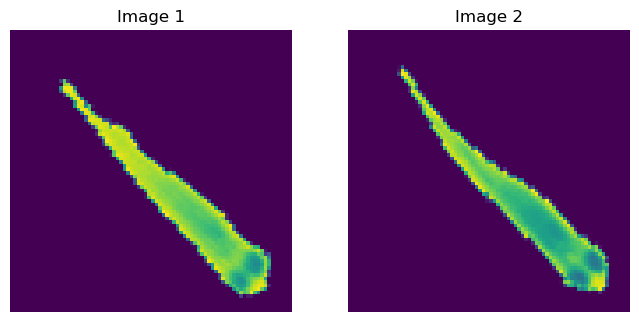

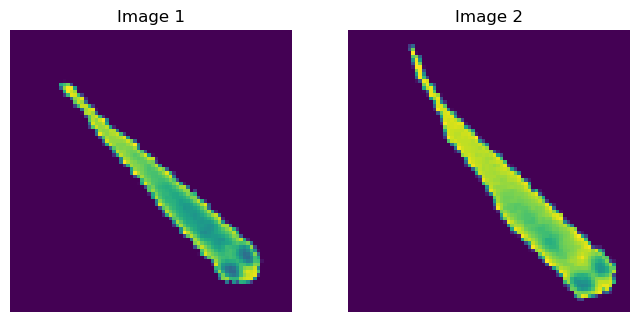

Starting epoch 1/25


100%|██████████| 239/239 [00:27<00:00,  8.75it/s]


Epoch [1/25] completed. Average Training Loss: 0.7410, Training Accuracy: 0.7315


100%|██████████| 48/48 [00:01<00:00, 27.75it/s]


Epoch [1/25] Validation Loss: 0.4336, Validation Accuracy: 0.8750
[Callback] Epoch 1 ended.
Training Loss: 0.7410, Training Accuracy: 0.7315
Validation Loss: 0.4336, Validation Accuracy: 0.8750
[Callback] Model saved at epoch 1
Starting epoch 2/25


100%|██████████| 239/239 [00:26<00:00,  8.92it/s]


Epoch [2/25] completed. Average Training Loss: 0.4343, Training Accuracy: 0.8637


100%|██████████| 48/48 [00:01<00:00, 27.67it/s]


Epoch [2/25] Validation Loss: 0.3610, Validation Accuracy: 0.9013
[Callback] Epoch 2 ended.
Training Loss: 0.4343, Training Accuracy: 0.8637
Validation Loss: 0.3610, Validation Accuracy: 0.9013
[Callback] Model saved at epoch 2
Starting epoch 3/25


100%|██████████| 239/239 [00:26<00:00,  8.89it/s]


Epoch [3/25] completed. Average Training Loss: 0.3727, Training Accuracy: 0.8887


100%|██████████| 48/48 [00:01<00:00, 27.95it/s]


Epoch [3/25] Validation Loss: 0.3665, Validation Accuracy: 0.9006
[Callback] Epoch 3 ended.
Training Loss: 0.3727, Training Accuracy: 0.8887
Validation Loss: 0.3665, Validation Accuracy: 0.9006
[Callback] Model saved at epoch 3
Starting epoch 4/25


100%|██████████| 239/239 [00:26<00:00,  8.91it/s]


Epoch [4/25] completed. Average Training Loss: 0.3296, Training Accuracy: 0.9068


100%|██████████| 48/48 [00:01<00:00, 27.52it/s]


Epoch [4/25] Validation Loss: 0.3458, Validation Accuracy: 0.9099
[Callback] Epoch 4 ended.
Training Loss: 0.3296, Training Accuracy: 0.9068
Validation Loss: 0.3458, Validation Accuracy: 0.9099
[Callback] Model saved at epoch 4
Starting epoch 5/25


100%|██████████| 239/239 [00:26<00:00,  8.89it/s]


Epoch [5/25] completed. Average Training Loss: 0.3042, Training Accuracy: 0.9185


100%|██████████| 48/48 [00:01<00:00, 27.95it/s]


Epoch [5/25] Validation Loss: 0.3190, Validation Accuracy: 0.9206
[Callback] Epoch 5 ended.
Training Loss: 0.3042, Training Accuracy: 0.9185
Validation Loss: 0.3190, Validation Accuracy: 0.9206
[Callback] Model saved at epoch 5
Starting epoch 6/25


100%|██████████| 239/239 [00:26<00:00,  8.91it/s]


Epoch [6/25] completed. Average Training Loss: 0.2861, Training Accuracy: 0.9246


100%|██████████| 48/48 [00:01<00:00, 27.96it/s]


Epoch [6/25] Validation Loss: 0.3101, Validation Accuracy: 0.9269
[Callback] Epoch 6 ended.
Training Loss: 0.2861, Training Accuracy: 0.9246
Validation Loss: 0.3101, Validation Accuracy: 0.9269
[Callback] Model saved at epoch 6
Starting epoch 7/25


100%|██████████| 239/239 [00:26<00:00,  8.91it/s]


Epoch [7/25] completed. Average Training Loss: 0.2644, Training Accuracy: 0.9344


100%|██████████| 48/48 [00:01<00:00, 27.38it/s]


Epoch [7/25] Validation Loss: 0.3327, Validation Accuracy: 0.9179
[Callback] Epoch 7 ended.
Training Loss: 0.2644, Training Accuracy: 0.9344
Validation Loss: 0.3327, Validation Accuracy: 0.9179
[Callback] Model saved at epoch 7
Starting epoch 8/25


100%|██████████| 239/239 [00:26<00:00,  8.95it/s]


Epoch [8/25] completed. Average Training Loss: 0.2485, Training Accuracy: 0.9393


100%|██████████| 48/48 [00:01<00:00, 27.14it/s]


Epoch [8/25] Validation Loss: 0.2836, Validation Accuracy: 0.9339
[Callback] Epoch 8 ended.
Training Loss: 0.2485, Training Accuracy: 0.9393
Validation Loss: 0.2836, Validation Accuracy: 0.9339
[Callback] Model saved at epoch 8
Starting epoch 9/25


100%|██████████| 239/239 [00:26<00:00,  8.91it/s]


Epoch [9/25] completed. Average Training Loss: 0.2290, Training Accuracy: 0.9477


100%|██████████| 48/48 [00:01<00:00, 28.05it/s]


Epoch [9/25] Validation Loss: 0.2790, Validation Accuracy: 0.9325
[Callback] Epoch 9 ended.
Training Loss: 0.2290, Training Accuracy: 0.9477
Validation Loss: 0.2790, Validation Accuracy: 0.9325
[Callback] Model saved at epoch 9
Starting epoch 10/25


100%|██████████| 239/239 [00:26<00:00,  8.95it/s]


Epoch [10/25] completed. Average Training Loss: 0.2135, Training Accuracy: 0.9507


100%|██████████| 48/48 [00:01<00:00, 27.63it/s]


Epoch [10/25] Validation Loss: 0.2789, Validation Accuracy: 0.9315
[Callback] Epoch 10 ended.
Training Loss: 0.2135, Training Accuracy: 0.9507
Validation Loss: 0.2789, Validation Accuracy: 0.9315
[Callback] Model saved at epoch 10
Starting epoch 11/25


100%|██████████| 239/239 [00:26<00:00,  8.92it/s]


Epoch [11/25] completed. Average Training Loss: 0.2037, Training Accuracy: 0.9573


100%|██████████| 48/48 [00:01<00:00, 27.00it/s]


Epoch [11/25] Validation Loss: 0.2566, Validation Accuracy: 0.9355
[Callback] Epoch 11 ended.
Training Loss: 0.2037, Training Accuracy: 0.9573
Validation Loss: 0.2566, Validation Accuracy: 0.9355
[Callback] Model saved at epoch 11
Starting epoch 12/25


100%|██████████| 239/239 [00:26<00:00,  8.91it/s]


Epoch [12/25] completed. Average Training Loss: 0.1836, Training Accuracy: 0.9649


100%|██████████| 48/48 [00:01<00:00, 27.80it/s]


Epoch [12/25] Validation Loss: 0.2920, Validation Accuracy: 0.9332
[Callback] Epoch 12 ended.
Training Loss: 0.1836, Training Accuracy: 0.9649
Validation Loss: 0.2920, Validation Accuracy: 0.9332
[Callback] Model saved at epoch 12
Starting epoch 13/25


100%|██████████| 239/239 [00:26<00:00,  8.87it/s]


Epoch [13/25] completed. Average Training Loss: 0.1659, Training Accuracy: 0.9711


100%|██████████| 48/48 [00:01<00:00, 27.34it/s]


Epoch [13/25] Validation Loss: 0.2716, Validation Accuracy: 0.9415
[Callback] Epoch 13 ended.
Training Loss: 0.1659, Training Accuracy: 0.9711
Validation Loss: 0.2716, Validation Accuracy: 0.9415
[Callback] Model saved at epoch 13
Starting epoch 14/25


100%|██████████| 239/239 [00:26<00:00,  8.90it/s]


Epoch [14/25] completed. Average Training Loss: 0.1566, Training Accuracy: 0.9768


100%|██████████| 48/48 [00:01<00:00, 27.75it/s]


Epoch [14/25] Validation Loss: 0.3020, Validation Accuracy: 0.9216
[Callback] Epoch 14 ended.
Training Loss: 0.1566, Training Accuracy: 0.9768
Validation Loss: 0.3020, Validation Accuracy: 0.9216
[Callback] Model saved at epoch 14
Starting epoch 15/25


100%|██████████| 239/239 [00:27<00:00,  8.83it/s]


Epoch [15/25] completed. Average Training Loss: 0.1387, Training Accuracy: 0.9825


100%|██████████| 48/48 [00:01<00:00, 27.68it/s]


Epoch [15/25] Validation Loss: 0.2778, Validation Accuracy: 0.9405
[Callback] Epoch 15 ended.
Training Loss: 0.1387, Training Accuracy: 0.9825
Validation Loss: 0.2778, Validation Accuracy: 0.9405
[Callback] Model saved at epoch 15
Starting epoch 16/25


100%|██████████| 239/239 [00:26<00:00,  8.87it/s]


Epoch [16/25] completed. Average Training Loss: 0.1259, Training Accuracy: 0.9861


100%|██████████| 48/48 [00:01<00:00, 27.00it/s]


Epoch [16/25] Validation Loss: 0.3306, Validation Accuracy: 0.9259
[Callback] Epoch 16 ended.
Training Loss: 0.1259, Training Accuracy: 0.9861
Validation Loss: 0.3306, Validation Accuracy: 0.9259
[Callback] Model saved at epoch 16
Starting epoch 17/25


100%|██████████| 239/239 [00:27<00:00,  8.77it/s]


Epoch [17/25] completed. Average Training Loss: 0.1109, Training Accuracy: 0.9908


100%|██████████| 48/48 [00:01<00:00, 27.73it/s]


Epoch [17/25] Validation Loss: 0.2932, Validation Accuracy: 0.9285
[Callback] Epoch 17 ended.
Training Loss: 0.1109, Training Accuracy: 0.9908
Validation Loss: 0.2932, Validation Accuracy: 0.9285
[Callback] Model saved at epoch 17
Starting epoch 18/25


100%|██████████| 239/239 [00:26<00:00,  8.85it/s]


Epoch [18/25] completed. Average Training Loss: 0.1015, Training Accuracy: 0.9925


100%|██████████| 48/48 [00:01<00:00, 27.39it/s]


Epoch [18/25] Validation Loss: 0.3057, Validation Accuracy: 0.9276
[Callback] Epoch 18 ended.
Training Loss: 0.1015, Training Accuracy: 0.9925
Validation Loss: 0.3057, Validation Accuracy: 0.9276
[Callback] Model saved at epoch 18
Starting epoch 19/25


100%|██████████| 239/239 [00:27<00:00,  8.85it/s]


Epoch [19/25] completed. Average Training Loss: 0.0909, Training Accuracy: 0.9960


100%|██████████| 48/48 [00:01<00:00, 27.44it/s]


Epoch [19/25] Validation Loss: 0.2883, Validation Accuracy: 0.9322
[Callback] Epoch 19 ended.
Training Loss: 0.0909, Training Accuracy: 0.9960
Validation Loss: 0.2883, Validation Accuracy: 0.9322
[Callback] Model saved at epoch 19
Starting epoch 20/25


100%|██████████| 239/239 [00:27<00:00,  8.81it/s]


Epoch [20/25] completed. Average Training Loss: 0.0801, Training Accuracy: 0.9967


100%|██████████| 48/48 [00:01<00:00, 27.50it/s]


Epoch [20/25] Validation Loss: 0.3239, Validation Accuracy: 0.9246
[Callback] Epoch 20 ended.
Training Loss: 0.0801, Training Accuracy: 0.9967
Validation Loss: 0.3239, Validation Accuracy: 0.9246
[Callback] Model saved at epoch 20
Starting epoch 21/25


100%|██████████| 239/239 [00:28<00:00,  8.45it/s]


Epoch [21/25] completed. Average Training Loss: 0.0675, Training Accuracy: 0.9982


100%|██████████| 48/48 [00:02<00:00, 23.14it/s]


Epoch [21/25] Validation Loss: 0.3265, Validation Accuracy: 0.9229
[Callback] Epoch 21 ended.
Training Loss: 0.0675, Training Accuracy: 0.9982
Validation Loss: 0.3265, Validation Accuracy: 0.9229
[Callback] Model saved at epoch 21
Starting epoch 22/25


100%|██████████| 239/239 [00:28<00:00,  8.38it/s]


Epoch [22/25] completed. Average Training Loss: 0.0623, Training Accuracy: 0.9986


100%|██████████| 48/48 [00:01<00:00, 26.34it/s]


Epoch [22/25] Validation Loss: 0.3442, Validation Accuracy: 0.9129
[Callback] Epoch 22 ended.
Training Loss: 0.0623, Training Accuracy: 0.9986
Validation Loss: 0.3442, Validation Accuracy: 0.9129
[Callback] Model saved at epoch 22
Starting epoch 23/25


100%|██████████| 239/239 [00:28<00:00,  8.37it/s]


Epoch [23/25] completed. Average Training Loss: 0.0538, Training Accuracy: 0.9993


100%|██████████| 48/48 [00:02<00:00, 23.64it/s]


Epoch [23/25] Validation Loss: 0.3079, Validation Accuracy: 0.9279
[Callback] Epoch 23 ended.
Training Loss: 0.0538, Training Accuracy: 0.9993
Validation Loss: 0.3079, Validation Accuracy: 0.9279
[Callback] Model saved at epoch 23
Starting epoch 24/25


100%|██████████| 239/239 [00:27<00:00,  8.64it/s]


Epoch [24/25] completed. Average Training Loss: 0.0474, Training Accuracy: 0.9993


100%|██████████| 48/48 [00:02<00:00, 23.83it/s]


Epoch [24/25] Validation Loss: 0.3020, Validation Accuracy: 0.9232
[Callback] Epoch 24 ended.
Training Loss: 0.0474, Training Accuracy: 0.9993
Validation Loss: 0.3020, Validation Accuracy: 0.9232
[Callback] Model saved at epoch 24
Starting epoch 25/25


100%|██████████| 239/239 [00:28<00:00,  8.33it/s]


Epoch [25/25] completed. Average Training Loss: 0.0453, Training Accuracy: 0.9995


100%|██████████| 48/48 [00:02<00:00, 23.84it/s]

Epoch [25/25] Validation Loss: 0.3383, Validation Accuracy: 0.9179
[Callback] Epoch 25 ended.
Training Loss: 0.0453, Training Accuracy: 0.9995
Validation Loss: 0.3383, Validation Accuracy: 0.9179
[Callback] Model saved at epoch 25
[Callback] Training completed.


In [188]:
# Check the number of classes and images
print(f"Number of classes in training set: {len(train_dataset)}")
print(f"Number of classes in validation set: {len(val_dataset)}")

# Define training dataset parameters
train_dataset_params = {
    'dataset_class': 'dataset',
    'data': train_dataset  # The image dataset built earlier
}

# Define validation dataset parameters
val_dataset_params = {
    'dataset_class': 'dataset',
    'data': val_dataset  # The image dataset built earlier
}
#'''

# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    val_dataset_params,
    training_params,
    callbacks
)


In [ ]:
predictor = SiamesePredictor(
    model_path=trained_model,
    model_params=model_params,
    #transform=trained_model.transform,
    threshold=training_params.get('threshold', 1.0)
)

# Define a function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    from tqdm import tqdm

    with torch.no_grad():
        for img1, img2, labels in tqdm(test_loader):
            #print(img1.shape, img2.shape, labels.shape)
            #print(f"single input: {predictor._is_single_image(img1)} for {img1.shape}")
            distance, prediction = predictor.predict(img1, img2)

            #print(f"Euclidean Distance: {distance:.4f}")
            #print(f"Prediction: {'Similar' if prediction == 0 else 'Dissimilar'}")

            # Compare predictions with labels
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model(trained_model, train_loader)

In [191]:
margin = training_params.get('margin', 2.0)
criterion = ContrastiveLoss(margin=margin)
threshold = training_params.get('threshold', margin / 2.0)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=0)
SiameseTrainer.validate_model(trained_model, val_loader, criterion, 'mps', threshold)

100%|██████████| 48/48 [00:01<00:00, 25.79it/s]


(0.3383007002994418, 0.9179129278830176)

In [192]:
for i, (label, id1, frame1, img1, id2, frame2, img2) in enumerate(all_positives):
    print(f"positive: label: {label}, id1: {id1}, frame1: {frame1}, id2: {id2}, frame2: {frame2}")
    break

examples = [all_negatives[n] for n in np.random.randint(0, len(all_negatives), 10)]
for i, (label, id1, frame1, img1, id2, frame2, img2) in enumerate(examples):
    print(f"negative: label: {label}, id1: {id1}, frame1: {frame1}, id2: {id2}, frame2: {frame2}")
    #break
#print(f"all_positives: {all_positives[0]}")
#print(f"all_negatives: {np.shape(all_negatives)}")

positive: label: 0.0, id1: 9, frame1: 18478, id2: 9, frame2: 15489
negative: label: 1.0, id1: 5, frame1: 2650, id2: 3, frame2: 2650
negative: label: 1.0, id1: 5, frame1: 19266, id2: 9, frame2: 19266
negative: label: 1.0, id1: 7, frame1: 6511, id2: 5, frame2: 6511
negative: label: 1.0, id1: 0, frame1: 1246, id2: 2, frame2: 1246
negative: label: 1.0, id1: 8, frame1: 9821, id2: 5, frame2: 9821
negative: label: 1.0, id1: 3, frame1: 6221, id2: 4, frame2: 6221
negative: label: 1.0, id1: 3, frame1: 2151, id2: 0, frame2: 2151
negative: label: 1.0, id1: 5, frame1: 11327, id2: 9, frame2: 11327
negative: label: 1.0, id1: 5, frame1: 445, id2: 9, frame2: 445
negative: label: 1.0, id1: 0, frame1: 17050, id2: 7, frame2: 17050


In [ ]:
# now sort the generated dataset into train and val folders
from sklearn.model_selection import train_test_split

# get all the folders
ids = glob(os.path.join(root, "*"))

# create the train and val folders
os.makedirs(os.path.join(root, 'train'), exist_ok=True)
os.makedirs(os.path.join(root, 'val'), exist_ok=True)

# split the ids into train and val
train_ids, val_ids = train_test_split(ids, test_size=0.2)

# move the folders to the correct location
for folder in train_ids:
    os.rename(folder, os.path.join(root, 'train', os.path.basename(folder)))

for folder in val_ids:
    os.rename(folder, os.path.join(root, 'val', os.path.basename(folder)))